# GNN-based URA Clustering

This notebook demonstrates Graph Neural Networks for clustering a $16 \times 16$ Uniform Rectangular Array (URA) using unsupervised learning with MinCut optimization.

**Architecture overview:**
1. Graph Construction: Convert URA grid to 8-connected graph with edge features
2. GNN Layers: GAT with edge features (PyTorch Geometric `GATConv`)
3. Clustering Head: Soft assignment via softmax
4. Loss: MinCut + Orthogonality (no labels needed)

## 1. Imports and Setup

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

# Import GNN modules
from gnn import (
    URAConfig,
    create_ura_graph,
    URAClusteringGNN,
    mincut_loss,
    orthogonality_loss,
    train_ura_clustering,
    assignments_to_antenna_format,
)

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

c:\Users\Andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.9.1+cpu
CUDA available: False


## 2. URA Configuration and Graph Construction

Define the $16 \times 16$ URA with fixed spacing and build the 8-connected grid graph.

In [2]:
# Configuration: dx = 0.5λ horizontal, dy = 0.7λ vertical
config = URAConfig(rows=16, cols=16, dx=0.5, dy=0.7, freq_ghz=10.0)
print(f"Array size: {config.N} elements")
print(f"Spacing: {config.dx}λ (horizontal) x {config.dy}λ (vertical)")
print(f"Wavelength: {config.wavelength*1e3:.1f} mm")

# Build graph
positions, edge_index, edge_attr = create_ura_graph(config, connectivity='8-connected')
print(f"\nGraph: {positions.shape[0]} nodes, {edge_index.shape[1]} edges")
print(f"Edge features shape: {edge_attr.shape}  (dm, dn, distance)")

Array size: 256 elements
Spacing: 0.5λ (horizontal) x 0.7λ (vertical)
Wavelength: 30.0 mm

Graph: 256 nodes, 1860 edges
Edge features shape: torch.Size([1860, 3])  (dm, dn, distance)


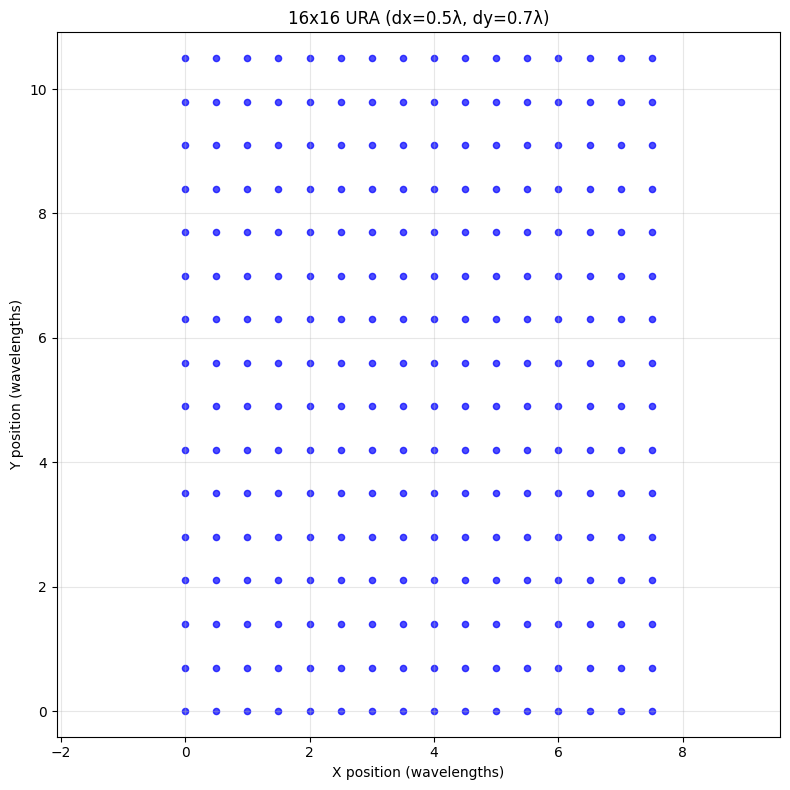

In [3]:
# Visualize the URA grid
plt.figure(figsize=(8, 8))
pos_np = positions.numpy()
plt.scatter(pos_np[:, 0], pos_np[:, 1], c='blue', s=20, alpha=0.7)
plt.xlabel('X position (wavelengths)')
plt.ylabel('Y position (wavelengths)')
plt.title(f'16x16 URA (dx={config.dx}λ, dy={config.dy}λ)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Train GNN Clustering

Train the GNN using `train_ura_clustering()` which follows the LaTeX specification exactly:
- 3 GAT layers (4 heads, 4 heads, 1 head) with edge features
- Input projection: Linear(2, 64)
- MinCut + Orthogonality loss
- Adam optimizer, lr=0.001, weight_decay=5e-4

In [4]:
# Train GNN
num_clusters = 4

print("Training GNN...\n")
clusters = train_ura_clustering(config, num_clusters=num_clusters, epochs=500, lr=0.001)
print(f"\nCluster sizes: {np.bincount(clusters)}")

Training GNN...

Epoch 100: Loss=-0.9622
Epoch 200: Loss=-0.9621
Epoch 300: Loss=-0.9630
Epoch 400: Loss=-0.9632
Epoch 500: Loss=-0.9633

Cluster sizes: [64 64 64 64]


## 4. Visualize Clustering Results

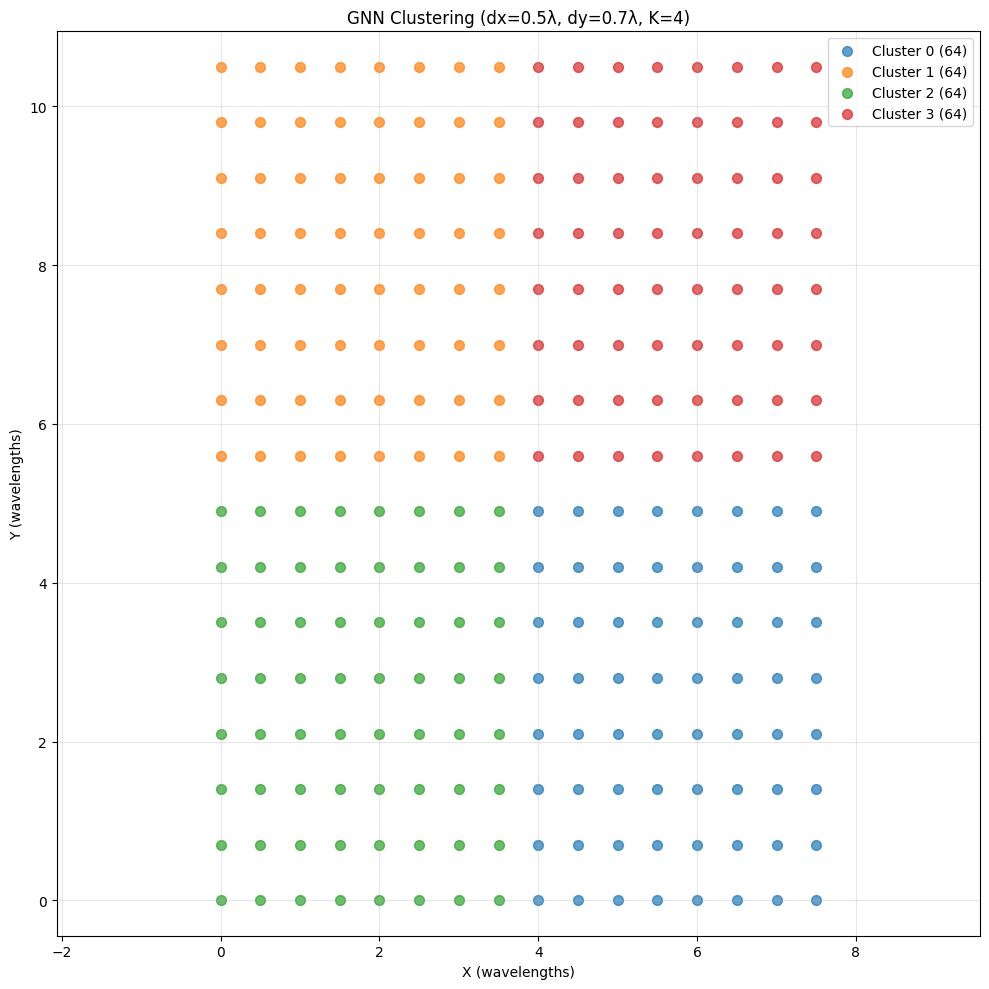

In [5]:
# Visualize clustering results
plt.figure(figsize=(10, 10))
colors = ['C0', 'C1', 'C2', 'C3']

pos_np = positions.numpy()
sizes = np.bincount(clusters)

for k in range(num_clusters):
    mask = clusters == k
    plt.scatter(pos_np[mask, 0], pos_np[mask, 1],
               c=colors[k], s=50, label=f'Cluster {k} ({sizes[k]})',
               alpha=0.7)

plt.xlabel('X (wavelengths)')
plt.ylabel('Y (wavelengths)')
plt.title(f'GNN Clustering (dx={config.dx}λ, dy={config.dy}λ, K={num_clusters})')
plt.legend(loc='upper right')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Radiation Pattern Plots

Compute the far-field pattern from the GNN clusters and plot the radiation pattern
using the same lobe-analysis layout used in clustering_comparison.ipynb.

In [6]:
import sys
from matplotlib.gridspec import GridSpec
from scipy.signal import find_peaks

# Add antenna physics utilities to path
sys.path.insert(0, '../optimization/pyvers')

from antenna_physics import (
    LatticeConfig,
    SystemConfig,
    MaskConfig,
    ElementPatternConfig,
    AntennaArray,
)
from gnn.utils import assignments_to_antenna_format


def extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight=None):
    """
    Extract lobe performance metrics from far-field pattern.
    """
    # Find boresight indices
    ele_idx = np.argmin(np.abs(ele - ele0))
    azi_idx = np.argmin(np.abs(azi - azi0))

    # Extract cuts
    ele_cut = FF_I_dB[:, azi_idx]  # Elevation cut at azimuth = azi0
    azi_cut = FF_I_dB[ele_idx, :]  # Azimuth cut at elevation = ele0

    # Main lobe gain
    main_lobe_gain = G_boresight if G_boresight else np.max(FF_I_dB)

    # HPBW (Half-Power Beam Width) - find -3dB points
    def find_hpbw(cut, angles):
        max_idx = np.argmax(cut)
        threshold = cut[max_idx] - 3

        # Find left -3dB point
        left_idx = max_idx
        for i in range(max_idx, -1, -1):
            if cut[i] < threshold:
                left_idx = i
                break

        # Find right -3dB point
        right_idx = max_idx
        for i in range(max_idx, len(cut)):
            if cut[i] < threshold:
                right_idx = i
                break

        return angles[right_idx] - angles[left_idx]

    hpbw_ele = find_hpbw(ele_cut, ele)
    hpbw_azi = find_hpbw(azi_cut, azi)

    # Side Lobe Level (relative to main lobe)
    def find_sll_relative(cut, angles):
        max_val = np.max(cut)
        max_idx = np.argmax(cut)

        # Find peaks excluding main lobe region
        peaks, _ = find_peaks(cut)

        # Filter peaks outside main lobe (-3dB region)
        threshold = max_val - 3
        side_peaks = [p for p in peaks if cut[p] < threshold]

        if side_peaks:
            max_side = max(cut[p] for p in side_peaks)
            return max_side  # Already relative (normalized pattern)
        return -30  # Default if no side lobes found

    sll_ele_relative = find_sll_relative(ele_cut, ele)
    sll_azi_relative = find_sll_relative(azi_cut, azi)

    # Count lobes
    peaks_ele, _ = find_peaks(ele_cut, height=-30)
    peaks_azi, _ = find_peaks(azi_cut, height=-30)

    return {
        'main_lobe_gain': main_lobe_gain,
        'hpbw_ele': hpbw_ele,
        'hpbw_azi': hpbw_azi,
        'sll_ele_relative': sll_ele_relative,
        'sll_azi_relative': sll_azi_relative,
        'n_lobes_ele': len(peaks_ele),
        'n_lobes_azi': len(peaks_azi),
        'ele_cut': ele_cut,
        'azi_cut': azi_cut,
    }


def plot_lobe_analysis(FF_I_dB, antenna_array, G_boresight=None,
                       title="Lobe Analysis", save_path=None):
    """
    Plot lobe analysis: elevation/azimuth cuts, 2D pattern, metrics table, polar plots.
    """
    ele0 = antenna_array.system.ele0
    azi0 = antenna_array.system.azi0
    ele = antenna_array.ele
    azi = antenna_array.azi

    metrics = extract_lobe_metrics(FF_I_dB, azi, ele, azi0, ele0, G_boresight)

    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)

    # 1. Elevation Cut with Lobes
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(ele, metrics['ele_cut'], 'b-', linewidth=2, label='Elevation Cut')
    ax1.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax1.axhline(y=metrics['sll_ele_relative'], color='g', linestyle=':', alpha=0.7,
                label=f"SLL: {metrics['sll_ele_relative']:.1f}dB")
    ax1.set_xlabel('Elevation [deg]')
    ax1.set_ylabel('Normalized Gain [dB]')
    ax1.set_title(f"Elevation Cut (azi={azi0} deg)\nHPBW={metrics['hpbw_ele']:.1f} deg")
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([-25, 25])

    # 2. Azimuth Cut with Lobes
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(azi, metrics['azi_cut'], 'b-', linewidth=2, label='Azimuth Cut')
    ax2.axhline(y=-3, color='r', linestyle='--', alpha=0.7, label='-3dB (HPBW)')
    ax2.axhline(y=metrics['sll_azi_relative'], color='g', linestyle=':', alpha=0.7,
                label=f"SLL: {metrics['sll_azi_relative']:.1f}dB")
    ax2.set_xlabel('Azimuth [deg]')
    ax2.set_ylabel('Normalized Gain [dB]')
    ax2.set_title(f"Azimuth Cut (ele={ele0} deg)\nHPBW={metrics['hpbw_azi']:.1f} deg")
    ax2.legend(loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([-25, 25])

    # 3. 2D Pattern (contour)
    ax3 = fig.add_subplot(gs[0, 2])
    levels = np.arange(-40, 5, 3)
    contour = ax3.contourf(antenna_array.AZI, antenna_array.ELE, FF_I_dB,
                           levels=levels, cmap='jet', extend='both')
    plt.colorbar(contour, ax=ax3, label='dB')
    ax3.plot(azi0, ele0, 'w*', markersize=15, markeredgecolor='k')
    ax3.set_xlabel('Azimuth [deg]')
    ax3.set_ylabel('Elevation [deg]')
    ax3.set_title('2D Far-Field Pattern')

    # 4. Metrics Summary Table
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.axis('off')

    table_data = [
        ['Main Lobe Gain', f"{metrics['main_lobe_gain']:.2f} dBi"],
        ['HPBW Elevation', f"{metrics['hpbw_ele']:.1f} deg"],
        ['HPBW Azimuth', f"{metrics['hpbw_azi']:.1f} deg"],
        ['SLL Elevation', f"{metrics['sll_ele_relative']:.1f} dB"],
        ['SLL Azimuth', f"{metrics['sll_azi_relative']:.1f} dB"],
        ['Lobes (Ele)', f"{metrics['n_lobes_ele']}"],
        ['Lobes (Azi)', f"{metrics['n_lobes_azi']}"],
    ]

    table = ax4.table(cellText=table_data, colLabels=['Metric', 'Value'],
                      loc='center', cellLoc='center',
                      colWidths=[0.5, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Performance Metrics', fontsize=12, fontweight='bold')

    # 5. Polar plot elevation
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    theta_rad = np.deg2rad(ele)
    r = metrics['ele_cut'] + 40  # Shift to positive
    ax5.plot(theta_rad, r, 'b-', linewidth=2)
    ax5.set_theta_zero_location('N')
    ax5.set_title('Elevation Pattern (Polar)', y=1.1)

    # 6. Polar plot azimuth
    ax6 = fig.add_subplot(gs[1, 2], projection='polar')
    theta_rad = np.deg2rad(azi)
    r = metrics['azi_cut'] + 40  # Shift to positive
    ax6.plot(theta_rad, r, 'b-', linewidth=2)
    ax6.set_theta_zero_location('N')
    ax6.set_title('Azimuth Pattern (Polar)', y=1.1)

    fig.suptitle(title, fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")

    plt.show()
    return metrics


C:\Users\Andrea\AppData\Local\Temp\ipykernel_33740\288661522.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


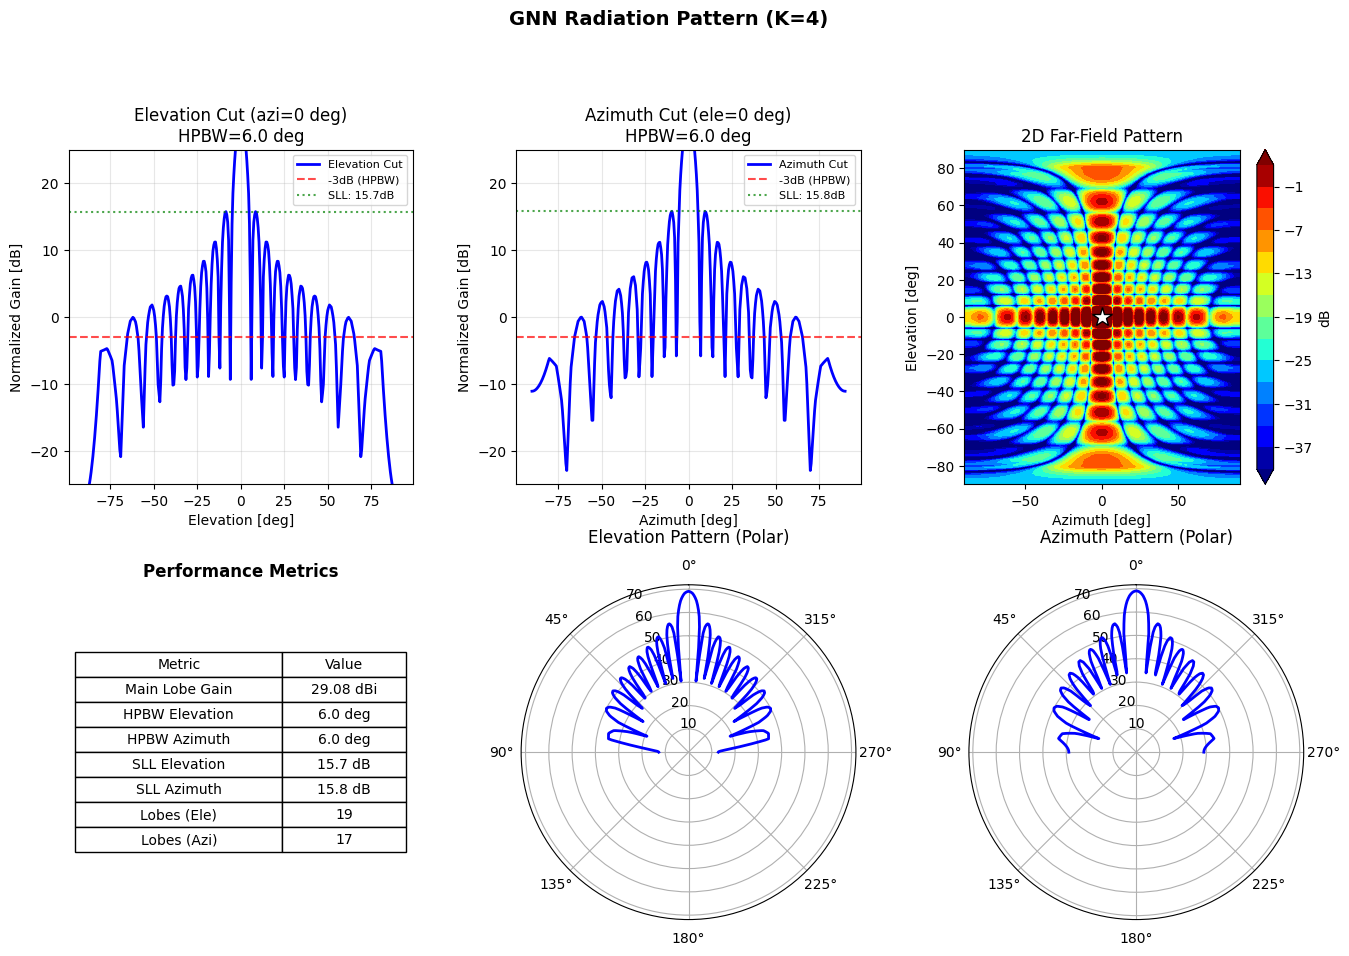

{'main_lobe_gain': np.float64(29.082399653987085),
 'hpbw_ele': np.float64(6.0),
 'hpbw_azi': np.float64(6.0),
 'sll_ele_relative': np.float64(15.728795363724908),
 'sll_azi_relative': np.float64(15.754782310225295),
 'n_lobes_ele': 19,
 'n_lobes_azi': 17,
 'ele_cut': array([-27.22670178, -27.1628404 , -26.97126113, -26.65197855,
        -26.20501699, -25.63041047, -24.92820277, -24.09844734,
        -23.14120739, -22.05655581, -20.8445752 , -19.50535785,
        -18.03900576, -16.44563059, -14.72535369, -12.87830605,
        -10.90462835,  -8.80447088,  -6.57799357,  -5.13940742,
         -5.0881326 ,  -5.03425572,  -4.97778089,  -4.91871239,
         -4.85705473,  -4.79281261,  -4.72599092,  -4.89154906,
         -5.19038528,  -5.49986733,  -5.81997166,  -6.15067388,
         -6.49194882,  -7.38638251,  -8.54836846,  -9.74400207,
        -10.97319228, -12.23584549, -13.92428887, -15.86391729,
        -17.85194114, -19.88820905, -20.87260269, -17.48349785,
        -14.0184697 , -10.47

In [7]:
# Antenna array configuration (same as clustering_comparison.ipynb)
lattice = LatticeConfig(Nz=16, Ny=16, dist_z=0.6, dist_y=0.53, lattice_type=1)
system = SystemConfig(freq=29.5e9, azi0=0, ele0=0, dele=0.5, dazi=0.5)
mask = MaskConfig(elem=30, azim=60, SLL_level=20, SLLin=15)
eef = ElementPatternConfig(P=1, Gel=5, load_file=0)

# Convert GNN assignments to antenna format
clusters_antenna = assignments_to_antenna_format(
    clusters, grid_shape=(lattice.Nz, lattice.Ny)
)

array = AntennaArray(lattice, system, mask, eef)
result_ff = array.evaluate_clustering(clusters_antenna)

plot_lobe_analysis(
    result_ff['FF_I_dB'],
    array,
    G_boresight=result_ff['G_boresight'],
    title=f"GNN Radiation Pattern (K={num_clusters})"
)